## Imports

In [39]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os

import seaborn as sns
import matplotlib.pyplot as plt
import sys

import skimage
from skimage.color import rgb2hsv
from skimage.transform import rescale, resize
from tqdm import tqdm

import sys
import os

from sklearn.metrics import classification_report


import bz2, pickle, _pickle as cPickle

import random

# random.seed(1234)

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/Modules/Testing")
import testing_module

SAVE_DIR = "../Pickled Datasets/"

COPIES = 2
N_DIGITS = 3
HEIGHT = 25
WIDTH  = 25


PLOT_SAVE = "../Plots/loss-curves/"

def compressed_pickle(name: str, data):
    with bz2.BZ2File(os.path.join(SAVE_DIR, "{}.pbz2".format(name)), 'w') as f:
        cPickle.dump(data, f)

def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data


def plot_history(history):
    acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    epochs=range(len(acc))

    fig, ax = plt.subplots(1, 2, figsize = (12, 6))
    ax[0].plot(epochs, acc, 'r', label = "Training Accuracy")
    ax[0].plot(epochs, val_acc, 'b', label = "Validation Accuracy")
    ax[0].legend()
    ax[0].set_title('Training and Validation Accuracy')
    ax[0].set_xlabel("Epochs")
    
    ax[1].plot(epochs, loss, 'r', label = "Training Loss")
    ax[1].plot(epochs, val_loss, 'b', label = "Validation Loss")
    ax[1].set_title('Training and Validation Losses')
    ax[1].set_xlabel("Epochs")
    plt.show()

    return (fig, ax)


SKImage rescales the image for us! Which means that we don't need to rescale by 255.0 anymore, saving us needlessly spent time and effort. There is another Augmentor library which can be used for data augmentation. We can simply sample the augmented images henceforth!

## Preliminary setup

In [3]:
sys.path.append(os.path.dirname(os.path.join((os.path.pardir), "Modules")))

origin_dir = os.path.join(os.path.pardir, 'Data')
new_dir_path = os.path.join(os.path.pardir, 'Data', 'cell_images')

#for local systems
train_csv = os.path.join(origin_dir, 'train.csv')
test_csv = os.path.join(origin_dir, 'test.csv')
val_csv = os.path.join(origin_dir, 'val.csv')

from Modules.labelling import Labelling

# download = Data_Download(origin_dir)
# data_dir = download.resize_image(new_dir_path, 44, 44)

lab = Labelling()
lab.label('../Data/cell_images/', exclude_mislabeled= True)      # function to label the dataset
train_csv, val_csv, test_csv = lab.train_test_val_split('../Data/', '../Data/cell_images/labels.csv', random_state = 1234)

In [4]:
train_data = pd.read_csv(train_csv)
val_data   = pd.read_csv(val_csv)
test_data  = pd.read_csv(test_csv)

### Reading images

In [5]:
def read_image(path):
    '''Function to read images given a path and return an array'''
    return skimage.io.imread(path)

../Data/cell_images/Parasitized\C39P4thinF_original_IMG_20150622_105102_cell_95.png
0.9966666666666667


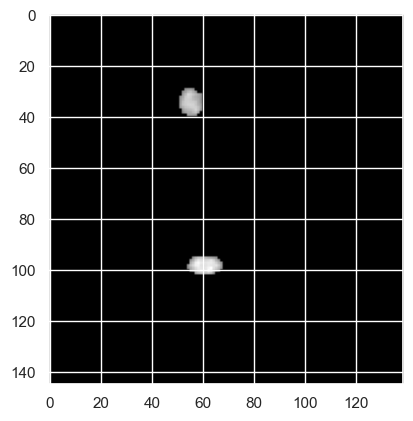

In [6]:
i = 14

print(train_data['Image_Path'][i])
image = rgb2hsv(skimage.io.imread(train_data['Image_Path'][i]))
print(np.max(image))
result = ((image > 0.5)*image)[..., 1]
plt.imshow(result, 'gray')

In [7]:
tqdm.pandas()
train_data['image_arr'] = train_data['Image_Path'].progress_apply(lambda x: read_image(x))
val_data['image_arr']   = val_data['Image_Path'].progress_apply(lambda x: read_image(x))
test_data['image_arr']  = test_data['Image_Path'].progress_apply(lambda x: read_image(x))


x_train, y_train = train_data['image_arr'].to_numpy(), train_data['Parasitized'].to_numpy()
x_val  , y_val   = val_data['image_arr'].to_numpy()  , val_data['Parasitized'].to_numpy()
x_test , y_test  = test_data['image_arr'].to_numpy() , test_data['Parasitized'].to_numpy()

100%|██████████| 2617/2617 [00:04<00:00, 636.81it/s]


## Data Augmentation

In [40]:
import albumentations as A
import cv2

In [41]:
augment = A.augmentations.geometric.transforms.Affine(
    translate_percent = 0.1,
    rotate = 60,
    shear = 30
    )

augment = A.ShiftScaleRotate(shift_limit = 0.01, rotate_limit= 90, border_mode=cv2.BORDER_CONSTANT, always_apply= True)

transform = A.Compose(
    [augment,
    A.VerticalFlip(p = 0.5),
    A.HorizontalFlip(p = 0.5),
    A.augmentations.geometric.Affine(shear = 10),
    A.Resize(HEIGHT, WIDTH, always_apply= True)
    ]
)

aug_dataset = []
aug_labels = []


for i, lab in tqdm(zip(x_train, y_train)):
    for _ in range(COPIES):
        aug_dataset.append(transform(image = i)['image'])
        aug_labels.append(lab)

20601it [00:05, 3583.55it/s]


In [42]:
x_train_aug = np.array(aug_dataset)
y_train_aug = np.array(aug_labels)

In [43]:
np.unique(y_train_aug, return_counts = True)

(array([0., 1.]), array([20520, 20682], dtype=int64))

### Resizing

In [44]:
temp = []
for img in tqdm(x_train):
    temp.append(resize(img, (HEIGHT, WIDTH)))
x_train = np.array(temp)


temp = []
for img in tqdm(x_val):
    temp.append(resize(img, (HEIGHT, WIDTH)))
x_val = np.array(temp)


temp = []
for img in tqdm(x_test):
    temp.append(resize(img, (HEIGHT, WIDTH)))
x_test = np.array(temp)

100%|██████████| 2617/2617 [00:00<00:00, 6500.95it/s]


## Saving Data

In [45]:
compressed_pickle("x_train_aug", x_train_aug)
compressed_pickle("y_train_aug", y_train_aug)
compressed_pickle("x_train", x_train)
compressed_pickle("y_train", y_train)
compressed_pickle("x_val", x_val)
compressed_pickle("y_val", y_val)
compressed_pickle("x_test", x_test)
compressed_pickle("y_test", y_test)

## Loading Data

In [14]:
x_train_aug = decompress_pickle(SAVE_DIR + 'x_train_aug.pbz2')
y_train_aug = decompress_pickle(SAVE_DIR + 'y_train_aug.pbz2')
x_train = decompress_pickle(SAVE_DIR + 'x_train.pbz2')
y_train = decompress_pickle(SAVE_DIR + 'y_train.pbz2')
x_val = decompress_pickle(SAVE_DIR + 'x_val.pbz2')
y_val = decompress_pickle(SAVE_DIR + 'y_val.pbz2')
x_test = decompress_pickle(SAVE_DIR + 'x_test.pbz2')
y_test = decompress_pickle(SAVE_DIR + 'y_test.pbz2')

print("augmented: ", x_train_aug.shape, y_train_aug.shape)
print("train: ", x_train.shape, y_train.shape)
print("val: ", x_val.shape, y_val.shape)
print("test: ", x_test.shape, y_test.shape)

augmented:  (41202, 25, 25, 3) (41202,)
train:  (20601, 25, 25, 3) (20601,)
val:  (2943, 25, 25, 3) (2943,)
test:  (2617, 25, 25, 3) (2617,)


In [15]:
n_aug_train = x_train_aug.shape[0]
n_train     = x_train.shape[0]
n_val       = x_val.shape[0]
n_test      = x_test.shape[0]

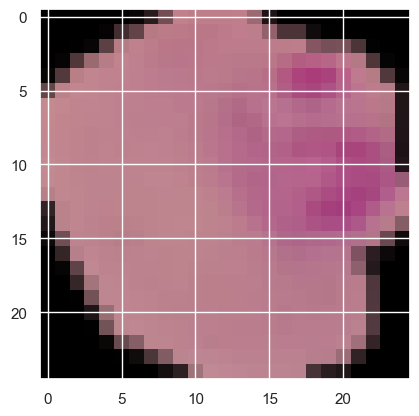

In [16]:
plt.imshow(x_train[3])

## Modeling

### Unaugmented

#### Naive Bayes

In [ ]:
from  import naive_bayes

nb_cls = naive_bayes.GaussianNB()
nb_cls.fit(x_train.reshape(n_train, -1), y_train)
preds_train = nb_cls.predict(x_train.reshape(n_train, -1))
preds_val   = nb_cls.predict(x_val.reshape(n_val, -1))
preds_test  = nb_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

# eval = testing_module.ModelEvaluation(y_val, 
#     nb_cls.predict(x_val.reshape(n_val, -1)),
#     model_reference_name = 'Naive Bayes',
#     model_type = 'classification',
#     plot_classification_metric = ['roc_auc']) # if classification
# eval.evaluate(evaluate_save= True, plots_show = True)

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.611     0.746     0.672     10260
         1.0      0.677     0.530     0.594     10341

    accuracy                          0.637     20601
   macro avg      0.644     0.638     0.633     20601
weighted avg      0.644     0.637     0.633     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.620     0.761     0.683      1466
         1.0      0.693     0.538     0.606      1477

    accuracy                          0.649      2943
   macro avg      0.657     0.649     0.644      2943
weighted avg      0.657     0.649     0.644      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.613     0.766     0.681      1303
         1.0      0.692     0.521     0.595      1314

    accuracy                          0.643      2617
   macro avg      0.653

#### Logistic Regression

Epoch 1/100
41/41 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.5583 - val_loss: 0.6503 - val_accuracy: 0.6317
Epoch 2/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6183 - val_loss: 0.6562 - val_accuracy: 0.5970
Epoch 3/100
41/41 [==============================] - 0s 4ms/step - loss: 0.6414 - accuracy: 0.6287 - val_loss: 0.6340 - val_accuracy: 0.6419
Epoch 4/100
41/41 [==============================] - 0s 4ms/step - loss: 0.6288 - accuracy: 0.6437 - val_loss: 0.6196 - val_accuracy: 0.6629
Epoch 5/100
41/41 [==============================] - 0s 4ms/step - loss: 0.6203 - accuracy: 0.6559 - val_loss: 0.6143 - val_accuracy: 0.6663
Epoch 6/100
41/41 [==============================] - 0s 4ms/step - loss: 0.6148 - accuracy: 0.6648 - val_loss: 0.6081 - val_accuracy: 0.6735
Epoch 7/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6111 - accuracy: 0.6689 - val_loss: 0.6148 - val_accuracy: 0.6687
Epoch 8/100
4

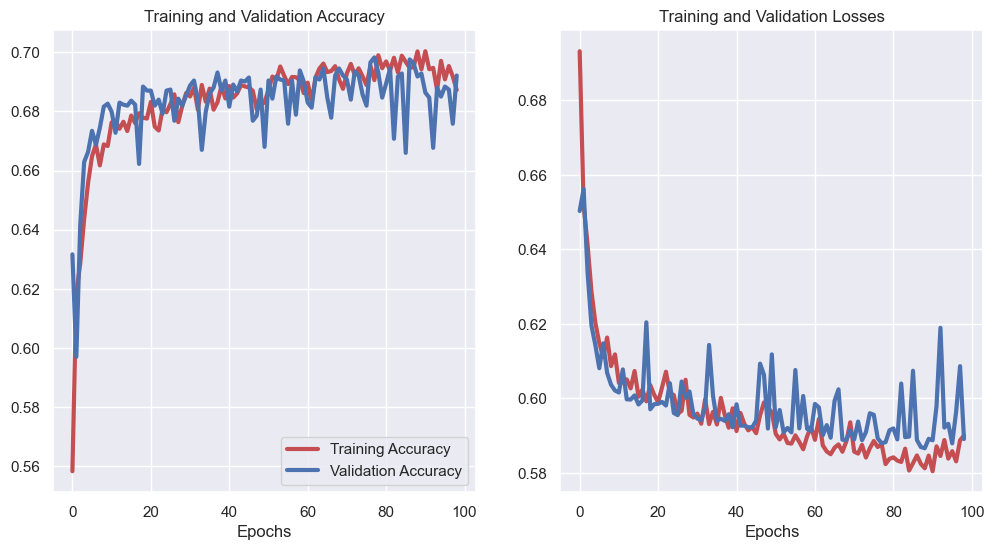

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.691     0.727     0.708     10260
         1.0      0.714     0.677     0.695     10341

    accuracy                          0.702     20601
   macro avg      0.702     0.702     0.702     20601
weighted avg      0.702     0.702     0.702     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.680     0.720     0.700      1466
         1.0      0.705     0.664     0.684      1477

    accuracy                          0.692      2943
   macro avg      0.693     0.692     0.692      2943
weighted avg      0.693     0.692     0.692      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.676     0.731     0.703      1303
         1.0      0.710     0.652     0.680      1314

    accuracy                          0.692      2617
   macro avg      0.693

In [71]:
from sklearn.linear_model import LogisticRegression

logreg_cls =  tf.keras.Sequential([tf.keras.layers.Dense(2, activation = 'sigmoid', input_dim = HEIGHT * WIDTH * 3)])
logreg_cls.compile(optimizer = tf.optimizers.Adam(0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = logreg_cls.fit(x_train.reshape(n_train, -1), 
                        y_train,
                        batch_size = 512,
                        validation_data=[x_val.reshape(n_val, -1), y_val],
                        validation_batch_size=128,
                        epochs = 100,
                        callbacks =  [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10),
                                     tf.keras.callbacks.ModelCheckpoint(str = 'val_loss', save_best_only = True, save_weights_only = True, filepath= "LR_No_Aug")],
                        verbose = 1)

logreg_cls.load_weights('LR_No_Aug')
preds_train = np.argmax(logreg_cls.predict(x_train.reshape(n_train, -1)), axis = 1)
preds_val   = np.argmax(logreg_cls.predict(x_val.reshape(n_val, -1)), axis = 1)
preds_test  = np.argmax(logreg_cls.predict(x_test.reshape(n_test, -1)), axis = 1)

fig, ax = plot_history(history)

fig.savefig(PLOT_SAVE + "logreg_unaug_losscurve.png", facecolor = 'white')

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

#### Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_cls =  DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_depth = 5, min_samples_split = 2, )
dt_cls.fit(x_train.reshape(n_train, -1), y_train)
preds_train = dt_cls.predict(x_train.reshape(n_train, -1))
preds_val   = dt_cls.predict(x_val.reshape(n_val, -1))
preds_test  = dt_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

# eval = testing_module.ModelEvaluation(y_val, 
#     nb_cls.predict(x_val.reshape(n_val, -1)),
#     model_reference_name = 'Naive Bayes',
#     model_type = 'classification',
#     plot_classification_metric = ['roc_auc']) # if classification
# eval.evaluate(evaluate_save= True, plots_show = True)

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.685     0.774     0.727     10260
         1.0      0.743     0.646     0.691     10341

    accuracy                          0.710     20601
   macro avg      0.714     0.710     0.709     20601
weighted avg      0.714     0.710     0.709     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.676     0.774     0.722      1466
         1.0      0.738     0.632     0.681      1477

    accuracy                          0.703      2943
   macro avg      0.707     0.703     0.701      2943
weighted avg      0.707     0.703     0.701      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.661     0.748     0.702      1303
         1.0      0.713     0.620     0.663      1314

    accuracy                          0.684      2617
   macro avg      0.687

#### XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb_cls = XGBClassifier(max_depth = 5, objective = 'reg:logistic',
                            num_parallel_tree = 20, booster = 'gbtree',
                            gamma = 0.5, tree_method = 'gpu_hist', subsample = 0.4, reg_lambda = 1)
xgb_cls.fit(x_train.reshape(n_train, -1), y_train)
preds_train = xgb_cls.predict(x_train.reshape(n_train, -1))
preds_val   = xgb_cls.predict(x_val.reshape(n_val, -1))
preds_test  = xgb_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))
                  

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.966     0.983     0.974     10260
         1.0      0.983     0.966     0.974     10341

    accuracy                          0.974     20601
   macro avg      0.974     0.974     0.974     20601
weighted avg      0.975     0.974     0.974     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.842     0.873     0.857      1466
         1.0      0.869     0.837     0.853      1477

    accuracy                          0.855      2943
   macro avg      0.855     0.855     0.855      2943
weighted avg      0.855     0.855     0.855      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.842     0.861     0.851      1303
         1.0      0.859     0.839     0.849      1314

    accuracy                          0.850      2617
   macro avg      0.850

#### SVM

In [ ]:
from sklearn.svm import SVC

svm_cls = SVC(kernel = 'poly', degree = 3, gamma = 'auto', max_iter = 250, verbose= True)
svm_cls.fit(x_train.reshape(n_train, -1), y_train)
preds_train = svm_cls.predict(x_train.reshape(n_train, -1))
preds_val   = svm_cls.predict(x_val.reshape(n_val, -1))
preds_test  = svm_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))
                  

[LibSVM]

c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.581     0.102     0.174     10260
         1.0      0.510     0.927     0.658     10341

    accuracy                          0.516     20601
   macro avg      0.545     0.515     0.416     20601
weighted avg      0.545     0.516     0.417     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.585     0.101     0.172      1466
         1.0      0.510     0.929     0.659      1477

    accuracy                          0.516      2943
   macro avg      0.548     0.515     0.415      2943
weighted avg      0.547     0.516     0.416      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.590     0.106     0.180      1303
         1.0      0.511     0.927     0.659      1314

    accuracy                          0.518      2617
   macro avg      0.550

#### Transfer Learning

Epoch 1/50
322/322 [==============================] - 8s 19ms/step - loss: 0.2402 - accuracy: 0.9129 - val_loss: 0.1393 - val_accuracy: 0.9460
Epoch 2/50
322/322 [==============================] - 5s 16ms/step - loss: 0.1315 - accuracy: 0.9504 - val_loss: 0.1533 - val_accuracy: 0.9463
Epoch 3/50
322/322 [==============================] - 5s 17ms/step - loss: 0.1123 - accuracy: 0.9571 - val_loss: 0.1205 - val_accuracy: 0.9562
Epoch 4/50
322/322 [==============================] - 5s 16ms/step - loss: 0.1025 - accuracy: 0.9610 - val_loss: 0.1225 - val_accuracy: 0.9565
Epoch 5/50
322/322 [==============================] - 5s 17ms/step - loss: 0.0903 - accuracy: 0.9646 - val_loss: 0.1103 - val_accuracy: 0.9606
Epoch 6/50
322/322 [==============================] - 5s 17ms/step - loss: 0.0894 - accuracy: 0.9664 - val_loss: 0.1001 - val_accuracy: 0.9660
Epoch 7/50
322/322 [==============================] - 5s 16ms/step - loss: 0.0824 - accuracy: 0.9682 - val_loss: 0.1644 - val_accuracy: 0.9450

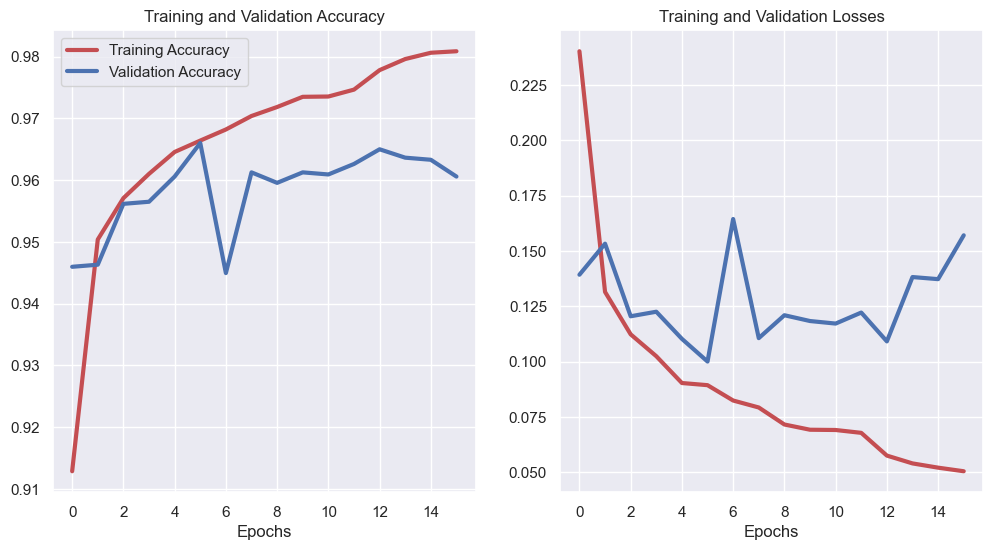

82/82 [==============================] - 1s 7ms/step
Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.963     0.988     0.975     10260
         1.0      0.987     0.962     0.975     10341

    accuracy                          0.975     20601
   macro avg      0.975     0.975     0.975     20601
weighted avg      0.975     0.975     0.975     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.957     0.976     0.966      1466
         1.0      0.976     0.956     0.966      1477

    accuracy                          0.966      2943
   macro avg      0.966     0.966     0.966      2943
weighted avg      0.966     0.966     0.966      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.948     0.974     0.961      1303
         1.0      0.973     0.947     0.960      1314

    accuracy            

In [69]:
imagenet = tf.keras.applications.Xception(
    weights = 'imagenet',
    include_top = False,
    input_shape = (72, 72, 3)
)
imagenet.trainable = False

trans_learn = tf.keras.Sequential([
    tf.keras.layers.Resizing(72, 72),
    imagenet,

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(2, activation = 'sigmoid')
])

trans_learn.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.003),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history = trans_learn.fit(
            x_train, y_train, batch_size = 64,
            shuffle = True,
            epochs = 50,
            validation_data = [x_val, y_val],
            validation_batch_size = 32,
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10),
                        tf.keras.callbacks.ModelCheckpoint(str = 'val_loss', save_best_only = True, save_weights_only = True, filepath= "TL_No_Aug")]
        )
fig, ax = plot_history(history)

trans_learn.load_weights('TL_No_Aug')

fig.savefig(PLOT_SAVE + "TL_unaug_losscurve.png", facecolor = 'white')
preds_train = np.argmax(trans_learn.predict(x_train), axis = 1)
preds_val   = np.argmax(trans_learn.predict(x_val), axis = 1)
preds_test  = np.argmax(trans_learn.predict(x_test), axis = 1)

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))



#### CNN Model

Epoch 1/50
21/21 [==============================] - 1s 15ms/step - loss: 0.6894 - accuracy: 0.5470 - val_loss: 0.6490 - val_accuracy: 0.6069
Epoch 2/50
21/21 [==============================] - 0s 10ms/step - loss: 0.6284 - accuracy: 0.6460 - val_loss: 0.5469 - val_accuracy: 0.7322
Epoch 3/50
21/21 [==============================] - 0s 10ms/step - loss: 0.5423 - accuracy: 0.7296 - val_loss: 0.4671 - val_accuracy: 0.7883
Epoch 4/50
21/21 [==============================] - 0s 8ms/step - loss: 0.4968 - accuracy: 0.7686 - val_loss: 0.4876 - val_accuracy: 0.7751
Epoch 5/50
21/21 [==============================] - 0s 9ms/step - loss: 0.4250 - accuracy: 0.8205 - val_loss: 0.3775 - val_accuracy: 0.8328
Epoch 6/50
21/21 [==============================] - 0s 10ms/step - loss: 0.3724 - accuracy: 0.8451 - val_loss: 0.3066 - val_accuracy: 0.8767
Epoch 7/50
21/21 [==============================] - 0s 10ms/step - loss: 0.3133 - accuracy: 0.8770 - val_loss: 0.2539 - val_accuracy: 0.9035
Epoch 8/50
21/2

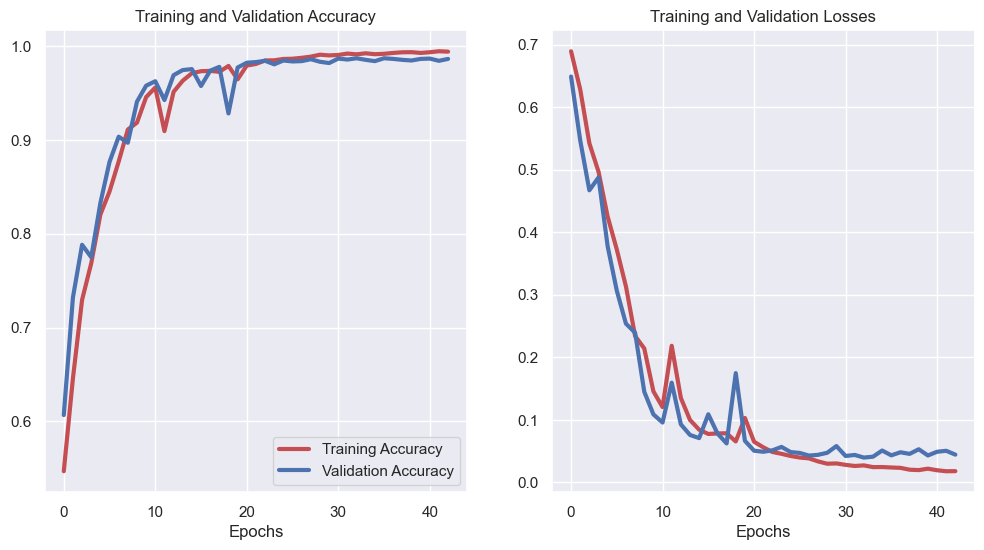

82/82 [==============================] - 0s 1ms/step
Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.992     0.996     0.994     10260
         1.0      0.996     0.992     0.994     10341

    accuracy                          0.994     20601
   macro avg      0.994     0.994     0.994     20601
weighted avg      0.994     0.994     0.994     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.985     0.989     0.987      1466
         1.0      0.989     0.985     0.987      1477

    accuracy                          0.987      2943
   macro avg      0.987     0.987     0.987      2943
weighted avg      0.987     0.987     0.987      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.977     0.988     0.983      1303
         1.0      0.988     0.977     0.983      1314

    accuracy            

In [72]:
cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), padding = 'same', activation = 'relu', input_shape = x_train[0].shape),
    tf.keras.layers.MaxPool2D((3,3), padding = 'same'),

    tf.keras.layers.Conv2D(32, (2,2), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D((2,2), padding = 'same'),


    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation = 'sigmoid')
])

cnn.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.003),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history = cnn.fit(
            x_train, y_train, batch_size = 1024,
            epochs = 50,
            validation_data = [x_val, y_val],
            validation_batch_size = 256,
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10),
                         tf.keras.callbacks.ModelCheckpoint(str = 'val_loss', save_best_only = True, save_weights_only = True, filepath= "CNN_No_Aug")]
        )


cnn.load_weights('CNN_No_Aug')
fig, ax = plot_history(history)

fig.savefig(PLOT_SAVE + "CNN_unaug_losscurve.png", facecolor = 'white')
preds_train = np.argmax(cnn.predict(x_train), axis = 1)
preds_val   = np.argmax(cnn.predict(x_val), axis = 1)
preds_test  = np.argmax(cnn.predict(x_test), axis = 1)

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

### Augmented Dataset

#### Naive Bayes

In [ ]:
from sklearn import naive_bayes

nb_cls = naive_bayes.GaussianNB()
nb_cls.fit(x_train_aug.reshape(n_aug_train, -1), y_train_aug)
preds_train = nb_cls.predict(x_train_aug.reshape(n_aug_train, -1))
preds_val   = nb_cls.predict(x_val.reshape(n_val, -1))
preds_test  = nb_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.620     0.746     0.677     20520
         1.0      0.684     0.547     0.608     20682

    accuracy                          0.646     41202
   macro avg      0.652     0.646     0.643     41202
weighted avg      0.652     0.646     0.642     41202


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.000     0.000     0.000      1466
         1.0      0.502     1.000     0.668      1477

    accuracy                          0.502      2943
   macro avg      0.251     0.500     0.334      2943
weighted avg      0.252     0.502     0.335      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.000     0.000     0.000      1303
         1.0      0.502     1.000     0.669      1314

    accuracy                          0.502      2617
   macro avg      0.251

c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\m

#### Logistic Regression

Epoch 1/100
81/81 [==============================] - 0s 4ms/step - loss: 0.6717 - accuracy: 0.5845 - val_loss: 0.6347 - val_accuracy: 0.6592
Epoch 2/100
81/81 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.6406 - val_loss: 0.6289 - val_accuracy: 0.6558
Epoch 3/100
81/81 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6436 - val_loss: 0.6297 - val_accuracy: 0.6561
Epoch 4/100
81/81 [==============================] - 0s 3ms/step - loss: 0.6287 - accuracy: 0.6604 - val_loss: 0.6186 - val_accuracy: 0.6755
Epoch 5/100
81/81 [==============================] - 0s 3ms/step - loss: 0.6242 - accuracy: 0.6667 - val_loss: 0.6195 - val_accuracy: 0.6697
Epoch 6/100
81/81 [==============================] - 0s 3ms/step - loss: 0.6249 - accuracy: 0.6657 - val_loss: 0.6186 - val_accuracy: 0.6758
Epoch 7/100
81/81 [==============================] - 0s 3ms/step - loss: 0.6225 - accuracy: 0.6699 - val_loss: 0.6172 - val_accuracy: 0.6779
Epoch 8/100
8

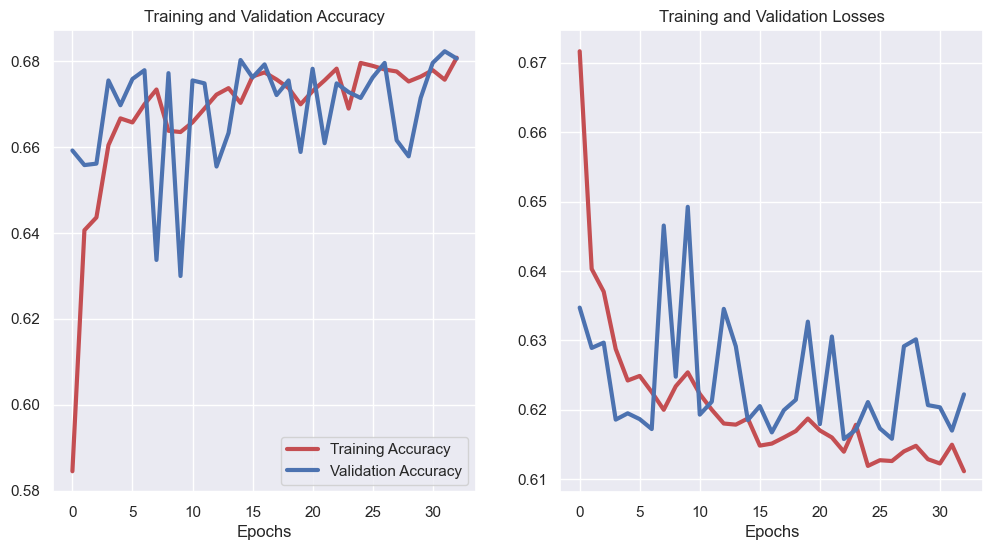

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.717     0.525     0.606     20520
         1.0      0.628     0.795     0.701     20682

    accuracy                          0.660     41202
   macro avg      0.672     0.660     0.654     41202
weighted avg      0.672     0.660     0.654     41202


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.717     0.593     0.649      1466
         1.0      0.655     0.768     0.707      1477

    accuracy                          0.681      2943
   macro avg      0.686     0.680     0.678      2943
weighted avg      0.686     0.681     0.678      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.701     0.579     0.634      1303
         1.0      0.644     0.755     0.695      1314

    accuracy                          0.667      2617
   macro avg      0.672

In [68]:
from sklearn.linear_model import LogisticRegression

logreg_cls =  tf.keras.Sequential([tf.keras.layers.Dense(2, activation = 'sigmoid', input_dim = HEIGHT * WIDTH * 3)])
logreg_cls.compile(optimizer = tf.optimizers.Adam(0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = logreg_cls.fit(x_train_aug.reshape(n_aug_train, -1), 
                        y_train_aug,
                        batch_size = 512,
                        validation_data=[x_val.reshape(n_val, -1), y_val],
                        validation_batch_size=128,
                        epochs = 100,
                        callbacks =  [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10),
                                    tf.keras.callbacks.ModelCheckpoint(str = 'val_loss', save_best_only = True, save_weights_only = True, filepath= "LR_Aug")])
preds_train = np.argmax(logreg_cls.predict(x_train_aug.reshape(n_aug_train, -1)), axis = 1)
preds_val   = np.argmax(logreg_cls.predict(x_val.reshape(n_val, -1)), axis = 1)
preds_test  = np.argmax(logreg_cls.predict(x_test.reshape(n_test, -1)), axis = 1)

logreg_cls.load_weights('LR_Aug')
fig, ax = plot_history(history)

fig.savefig(PLOT_SAVE + "logreg_aug_losscurve.png", facecolor = 'white')

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

#### Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_cls =  DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_depth = 20, min_samples_split = 2, )
dt_cls.fit(x_train_aug.reshape(n_aug_train, -1), y_train_aug)
preds_train = dt_cls.predict(x_train_aug.reshape(n_aug_train, -1))
preds_val   = dt_cls.predict(x_val.reshape(n_val, -1))
preds_test  = dt_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

# eval = testing_module.ModelEvaluation(y_val, 
#     nb_cls.predict(x_val.reshape(n_val, -1)),
#     model_reference_name = 'Naive Bayes',
#     model_type = 'classification',
#     plot_classification_metric = ['roc_auc']) # if classification
# eval.evaluate(evaluate_save= True, plots_show = True)

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.859     0.962     0.908     20520
         1.0      0.957     0.844     0.897     20682

    accuracy                          0.903     41202
   macro avg      0.908     0.903     0.902     41202
weighted avg      0.908     0.903     0.902     41202


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.690     0.802     0.741      1466
         1.0      0.765     0.642     0.698      1477

    accuracy                          0.721      2943
   macro avg      0.727     0.722     0.720      2943
weighted avg      0.727     0.721     0.720      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.679     0.815     0.741      1303
         1.0      0.771     0.617     0.686      1314

    accuracy                          0.716      2617
   macro avg      0.725

#### XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb_cls = XGBClassifier(max_depth = 5, objective = 'reg:logistic',
                            num_parallel_tree = 20, booster = 'gbtree',
                            gamma = 0.5, tree_method = 'gpu_hist', subsample = 0.4, reg_lambda = 1)
xgb_cls.fit(x_train_aug.reshape(n_aug_train, -1), y_train_aug)
preds_train = xgb_cls.predict(x_train_aug.reshape(n_aug_train, -1))
preds_val   = xgb_cls.predict(x_val.reshape(n_val, -1))
preds_test  = xgb_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))
                  

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.910     0.947     0.928     20520
         1.0      0.945     0.907     0.926     20682

    accuracy                          0.927     41202
   macro avg      0.928     0.927     0.927     41202
weighted avg      0.928     0.927     0.927     41202


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.840     0.884     0.861      1466
         1.0      0.879     0.833     0.855      1477

    accuracy                          0.858      2943
   macro avg      0.859     0.858     0.858      2943
weighted avg      0.859     0.858     0.858      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.833     0.883     0.857      1303
         1.0      0.876     0.824     0.849      1314

    accuracy                          0.853      2617
   macro avg      0.854

#### SVM

In [ ]:
from sklearn.svm import SVC

svm_cls = SVC(kernel = 'rbf', max_iter = 250, verbose= True)
svm_cls.fit(x_train_aug.reshape(n_aug_train, -1), y_train_aug)
preds_train = svm_cls.predict(x_train_aug.reshape(n_aug_train, -1))
preds_val   = svm_cls.predict(x_val.reshape(n_val, -1))
preds_test  = svm_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))
                  

[LibSVM]

c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.428     0.210     0.282     20520
         1.0      0.479     0.721     0.576     20682

    accuracy                          0.467     41202
   macro avg      0.453     0.466     0.429     41202
weighted avg      0.453     0.467     0.429     41202


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.430     0.204     0.277      1466
         1.0      0.481     0.731     0.580      1477

    accuracy                          0.469      2943
   macro avg      0.455     0.468     0.428      2943
weighted avg      0.455     0.469     0.429      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.427     0.194     0.267      1303
         1.0      0.481     0.741     0.584      1314

    accuracy                          0.469      2617
   macro avg      0.454

#### Transfer Learning

Epoch 1/50
322/322 [==============================] - 11s 27ms/step - loss: 0.2280 - accuracy: 0.9034 - val_loss: 0.1471 - val_accuracy: 0.9463
Epoch 2/50
322/322 [==============================] - 8s 26ms/step - loss: 0.1619 - accuracy: 0.9337 - val_loss: 0.1326 - val_accuracy: 0.9501
Epoch 3/50
322/322 [==============================] - 8s 26ms/step - loss: 0.1482 - accuracy: 0.9413 - val_loss: 0.1218 - val_accuracy: 0.9565
Epoch 4/50
322/322 [==============================] - 8s 25ms/step - loss: 0.1340 - accuracy: 0.9463 - val_loss: 0.1321 - val_accuracy: 0.9511
Epoch 5/50
322/322 [==============================] - 8s 25ms/step - loss: 0.1278 - accuracy: 0.9491 - val_loss: 0.1636 - val_accuracy: 0.9375
Epoch 6/50
322/322 [==============================] - 8s 24ms/step - loss: 0.1211 - accuracy: 0.9520 - val_loss: 0.1255 - val_accuracy: 0.9531
Epoch 7/50
322/322 [==============================] - 8s 25ms/step - loss: 0.1117 - accuracy: 0.9576 - val_loss: 0.1364 - val_accuracy: 0.950

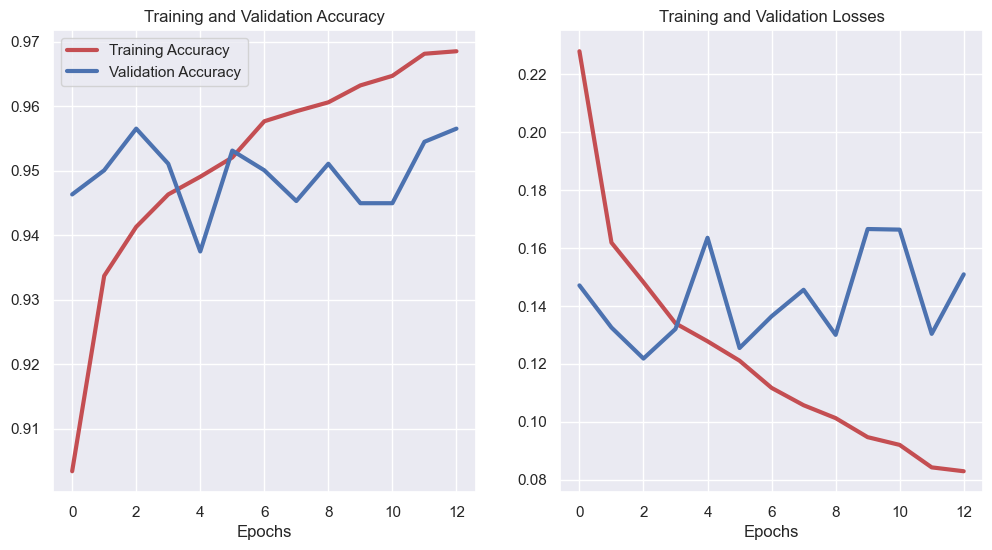

82/82 [==============================] - 1s 7ms/step
Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.921     0.975     0.947     20520
         1.0      0.973     0.917     0.944     20682

    accuracy                          0.946     41202
   macro avg      0.947     0.946     0.946     41202
weighted avg      0.947     0.946     0.946     41202


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.956     0.957     0.956      1466
         1.0      0.957     0.956     0.957      1477

    accuracy                          0.957      2943
   macro avg      0.957     0.957     0.957      2943
weighted avg      0.957     0.957     0.957      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.958     0.962     0.960      1303
         1.0      0.962     0.958     0.960      1314

    accuracy            

In [67]:
imagenet = tf.keras.applications.Xception(
    weights = 'imagenet',
    include_top = False,
    input_shape = (72, 72, 3)
)
imagenet.trainable = False

trans_learn = tf.keras.Sequential([
    tf.keras.layers.Resizing(72, 72),
    imagenet,

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(2, activation = 'sigmoid')
])

trans_learn.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history = trans_learn.fit(
            x_train_aug, y_train_aug, batch_size = 128,
            shuffle = True,
            epochs = 50,
            validation_data = [x_val, y_val],
            validation_batch_size = 64,
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10),
                        tf.keras.callbacks.ModelCheckpoint(str = 'val_loss', save_best_only = True, save_weights_only = True, filepath= "TL_Aug")]
        )

trans_learn.load_weights('TL_Aug')

fig, ax = plot_history(history)

fig.savefig(PLOT_SAVE + "TL_aug_losscurve.png", facecolor = 'white')
preds_train = np.argmax(trans_learn.predict(x_train_aug), axis = 1)
preds_val   = np.argmax(trans_learn.predict(x_val), axis = 1)
preds_test  = np.argmax(trans_learn.predict(x_test), axis = 1)

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))



#### CNN Model

Epoch 1/50
161/161 [==============================] - 6s 29ms/step - loss: 0.4880 - accuracy: 0.7363 - val_loss: 0.0826 - val_accuracy: 0.9694
Epoch 2/50
161/161 [==============================] - 4s 24ms/step - loss: 0.1094 - accuracy: 0.9631 - val_loss: 0.0499 - val_accuracy: 0.9844
Epoch 3/50
161/161 [==============================] - 4s 23ms/step - loss: 0.0655 - accuracy: 0.9790 - val_loss: 0.0526 - val_accuracy: 0.9837
Epoch 4/50
161/161 [==============================] - 4s 24ms/step - loss: 0.0560 - accuracy: 0.9826 - val_loss: 0.0472 - val_accuracy: 0.9827
Epoch 5/50
161/161 [==============================] - 4s 23ms/step - loss: 0.0474 - accuracy: 0.9857 - val_loss: 0.0698 - val_accuracy: 0.9742
Epoch 6/50
161/161 [==============================] - 4s 24ms/step - loss: 0.0440 - accuracy: 0.9865 - val_loss: 0.0423 - val_accuracy: 0.9864
Epoch 7/50
161/161 [==============================] - 4s 24ms/step - loss: 0.0403 - accuracy: 0.9882 - val_loss: 0.0340 - val_accuracy: 0.9888

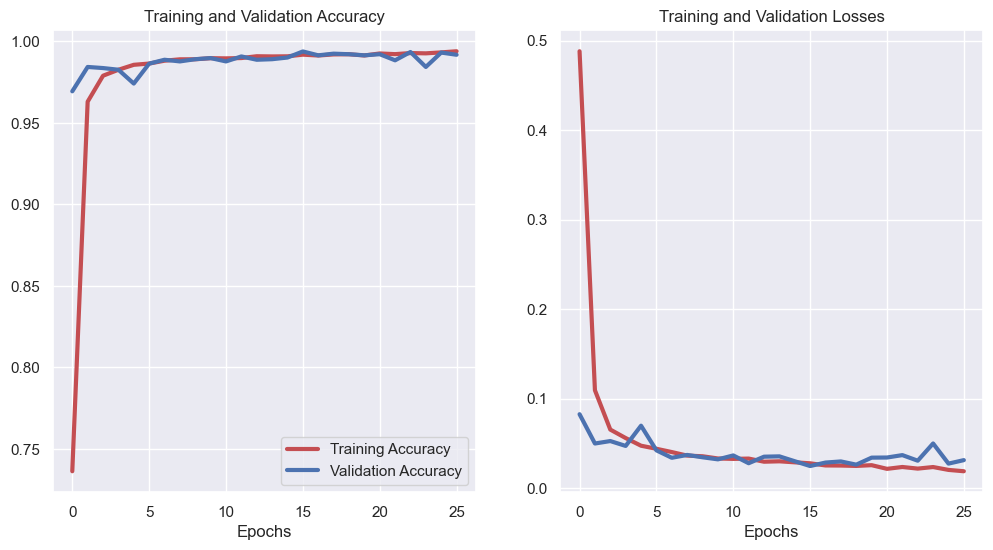

82/82 [==============================] - 0s 2ms/step
Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.985     0.997     0.991     20520
         1.0      0.997     0.985     0.991     20682

    accuracy                          0.991     41202
   macro avg      0.991     0.991     0.991     41202
weighted avg      0.991     0.991     0.991     41202


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.994     0.994     0.994      1466
         1.0      0.994     0.994     0.994      1477

    accuracy                          0.994      2943
   macro avg      0.994     0.994     0.994      2943
weighted avg      0.994     0.994     0.994      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.991     0.995     0.993      1303
         1.0      0.995     0.991     0.993      1314

    accuracy            

In [66]:
cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu', input_shape = x_train_aug[0].shape),
    tf.keras.layers.MaxPool2D((3,3), padding = 'same'),

    tf.keras.layers.UpSampling2D((5,5)),

    tf.keras.layers.Conv2D(64, (4,4), padding = 'same', activation = 'relu', input_shape = x_train_aug[0].shape),
    tf.keras.layers.MaxPool2D((4,4), padding = 'same'),

    tf.keras.layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D((3,3), padding = 'same'),


    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation = 'sigmoid')
])

cnn.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history = cnn.fit(
            x_train_aug, y_train_aug, batch_size = 256,
            epochs = 50,
            shuffle = True,
            validation_data = [x_val, y_val],
            validation_batch_size = 128,
            callbacks = [
                tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10),
                tf.keras.callbacks.ModelCheckpoint(str = 'val_loss', save_best_only = True, save_weights_only = True, filepath= "CNN_Aug")
            ]
        )

fig, ax = plot_history(history)

cnn.load_weights('CNN_Aug')

fig.savefig(PLOT_SAVE + "CNN_aug_losscurve.png", facecolor = 'white')
preds_train = np.argmax(cnn.predict(x_train_aug), axis = 1)
preds_val   = np.argmax(cnn.predict(x_val), axis = 1)
preds_test  = np.argmax(cnn.predict(x_test), axis = 1)

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))